# 1. Chargement du dataset

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Graine pour la reproductibilité
tf.keras.utils.set_random_seed(24)
tf.config.experimental.enable_op_determinism()

# Dataframe PVF-10
csv_pvf10 = "../data/processed/structure_pvf_10.csv"

# Répertoire des résultats
results_dir = "DL_images_results_EfficientNetV2"

In [2]:
from sklearn.model_selection import train_test_split

# Charger le dataframe à partir du dataset
def load_df_from_dataset(csv_path,*,format,originalTrainTest=False,removeCarre=False):
    # Charger le fichier CSV et filtrer sur le format sélectionné
    df_pvf10 = pd.read_csv(csv_path)
    df_pvf10 = df_pvf10.loc[(df_pvf10['Format'] == format)]
    # Retrait éventuel des images carrées mises en doute lors de l'analyse exploratoire
    if removeCarre:
        df_pvf10 = df_pvf10.loc[~df_pvf10['Doute_Carre']]
    # Si on utilise le découpage train/test proposé par les créateurs du dataset
    if originalTrainTest:
        df_train = df_pvf10.loc[(df_pvf10['Train_Test'] == 'train')]  
        df_test = df_pvf10.loc[(df_pvf10['Train_Test'] == 'test')] 
        X_train = df_train.drop('Classe',axis=1)
        y_train = df_train['Classe']
        X_test = df_test.drop('Classe',axis=1)
        y_test = df_test['Classe']
    # Sinon découpage train/test en 80/20 avec conservation de la répartition des classes
    else:
        X = df_pvf10.drop('Classe',axis=1)
        y = df_pvf10['Classe']
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
    
    return X_train,X_test,y_train,y_test

# Charger les images au format 110x60 avec le découpage train / test d'origine (90% / 10%)  
# On réserve 20% de train pour la validation
X_train,X_test,y_train,y_test = load_df_from_dataset(csv_pvf10,format="110x60",originalTrainTest="True")
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42,stratify=y_train)

print ("Nb d'images ensemble d'entraînement :",X_train.shape[0])
print ("Nb d'images ensemble de validation :",X_val.shape[0])
print ("Nb d'images ensemble de test :",X_test.shape[0])
print ("-"*20)
print ("Répartition des classes, ensemble d'entraînement :")
print(y_train.value_counts(normalize=True))
print ("-"*20)
print ("Répartition des classes, ensemble de validation :")
print(y_val.value_counts(normalize=True))
print ("-"*20)
print ("Répartition des classes, ensemble de test :")
print(y_test.value_counts(normalize=True))

pd.set_option('display.max_columns', None)

Nb d'images ensemble d'entraînement : 4015
Nb d'images ensemble de validation : 1004
Nb d'images ensemble de test : 553
--------------------
Répartition des classes, ensemble d'entraînement :
Classe
healthy panel             0.271980
hot cell                  0.169365
junction box heat         0.143462
substring open circuit    0.106600
short circuit panel       0.076712
Debris cover              0.073474
bottom dirt               0.067746
shadow                    0.054296
break                     0.023661
string short circuit      0.012702
Name: proportion, dtype: float64
--------------------
Répartition des classes, ensemble de validation :
Classe
healthy panel             0.271912
hot cell                  0.169323
junction box heat         0.143426
substring open circuit    0.106574
short circuit panel       0.076693
Debris cover              0.073705
bottom dirt               0.067729
shadow                    0.054781
break                     0.022908
string short circuit     

# 2. Preprocessing

Nous passerons en entrée de notre modèle un **tf.data.Dataset découpé en batch de 32 images**. Celles-ci seront **converties en niveaux de gris et redimensionnées au format 260x260x3 pour compatibilité avec EfficientNetV2B2**.

In [3]:
from tensorflow.keras.applications import EfficientNetV2B2

# Features : récupération des chemins d'images
X_train_path = X_train['Chemin'].values
X_val_path = X_val['Chemin'].values
X_test_path = X_test['Chemin'].values

# Targets : Encodage des classes en entier
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc = encoder.transform(y_val)
y_test_enc = encoder.transform(y_test)

# Fonction de preprocessing
def preprocess_path(path, label):
    image = tf.io.read_file(path) # Lecture du fichier
    image = tf.image.decode_png(image, channels=3) # Chargement de l'image 
    image = tf.image.rgb_to_grayscale(image) # Conversion en niveaux de gris
    image = tf.image.grayscale_to_rgb(image) # Passage en 3 canaux pour compatibilité EfficientNet
    image = tf.image.resize(image, [260, 260]) # Redimensionnement en 260x260
    return image, label

# Création des datasets tensorflow
train_ds = tf.data.Dataset.from_tensor_slices((X_train_path, y_train_enc))
val_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val_enc))
test_ds = tf.data.Dataset.from_tensor_slices((X_test_path, y_test_enc))

# Preprocessing
train_ds = train_ds.map(preprocess_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_path, num_parallel_calls=tf.data.AUTOTUNE)

# Optimisation de la pipeline
BATCH_SIZE = 32
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Nombre de batch dans train_ds:", train_ds.cardinality().numpy())
print("Nombre de batch dans val_ds:", val_ds.cardinality().numpy())
print("Nombre de batch dans test_ds:", test_ds.cardinality().numpy())

Nombre de batch dans train_ds: 126
Nombre de batch dans val_ds: 32
Nombre de batch dans test_ds: 18


# 3. Construction du modèle

Nous construisons un modèle avec EfficientNetV2B2 pour backbone :
- couche d'entrée au format (260,260,3)
- couches d'augmentation des données
- couches d'extraction de features : backbone EfficientNetV2B2
- couche de passage en 1D : Global Average Pooling
- couches de classification : basé sur couches denses

Pour plus de flexibilité, nous définissons une fonction qui construit un modèle en rendant paramétrables certains aspects de cette architecture 

In [ ]:
# Importations des couches du modèle
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomBrightness
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization


# Construction du modèle
def build_model(augmentation = False, unfreeze_from_block = "", head_option = 1):
    """
    Construit un modèle adaptable basé sur EfficientNetV2B2 pour la classification d'images 128x128.

    Args:
        augmentation (bool): Si True, applique des couches d'augmentation de données aux images.
        unfreeze_from_block (str): Bloc du backbone à partir duquel on dégèle les couches (typiquement block6 à block1)
        head_option (int) : Options d'architecture pour la tête du modèle

    Returns:
        keras.Model: Le modèle construit, prêt à être compilé et entraîné.
    """

    # Charger le modèle EfficientNetV2B2 sans la partie supérieure
    base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(260,260,3))

    # On le gèle par défaut 
    base_model.trainable = False

    # Dégel des dernières couches si demandé
    if unfreeze_from_block:
        # Au début pas de dégel
        start_unfreeze=False
        for layer in base_model.layers:
            # On commence le dégel à partir du bloc demandé
            if unfreeze_from_block in layer.name:
                start_unfreeze=True
            # On dégèle toutes les couches finales sauf BatchNormalization pour une meilleure stabilité
            if start_unfreeze:
                if not isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = True

    # Entrée
    inputs = Input(shape=(260,260,3))

    # Augmentation
    if augmentation:
        x = RandomFlip("horizontal_and_vertical")(inputs)
        x = RandomBrightness(factor=0.1)(x)
        x = RandomContrast(factor=0.1)(x)
        x = GaussianNoise(0.03)(x)
        # Backbone
        x = base_model(x)
    else:
        x = base_model(inputs)

    # Passage 1-D pour la classification
    x = GlobalAveragePooling2D()(x)

    # Couches de classification
    if head_option == 1:
        x = Dropout(0.3)(x)
    elif head_option == 2:
        x = Dense(256, activation="relu")(x)
        x = Dropout(0.4)(x)
    elif head_option == 3:
        x = Dense(512, activation="relu")(x)
        x = Dropout(0.4)(x)
        x = Dense(128, activation="relu")(x)
        x = Dropout(0.3)(x)
    elif head_option == 4:
        x = Dense(256, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.4)(x)
        x = Dense(64, activation="relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.3)(x)

    # Sortie
    outputs = Dense(units = 10, activation = 'softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return(model)

# 4. Optimisation des couches de classification (backbone gelé)

Nous commençons par **geler le backbone** : poids de EfficientNetV2B2 entraînés sur ImageNet. Nous cherchons à **optimiser la tête** du modèle (couches de classification).
Nous ferons le fine-tuning dans un second temps.

Pour limiter les risques de sur-apprentissage, nous allons utiliser les callbacks EarlyStopping et ReduceLROnPlateau

In [5]:
# Arrêt après 5 époques si la perte sur l'ensemble de validation ne diminue plus
from tensorflow.keras.callbacks import EarlyStopping 
early_stopping = EarlyStopping(monitor = 'val_loss',
                               mode = 'min',
                               patience = 5,
                               verbose = 1,
                               restore_best_weights=True)

# Taux d'apprentissage divisé par 2 si la perte sur l'ensemble de validation ne diminue plus après 3 époques.
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss',
                               mode = 'min',
                               patience = 3,
                               factor = 0.5, 
                               min_lr=1e-6,
                               verbose = 1)

Nous définissons dès maintenant une fonction de prédiction : celle-ci sera utilisée sur l'ensemble de validation et permettra notamment de calculer le f1-score

In [6]:
# Fonction de prédiction d'un dataset
def get_predictions_and_labels(model,dataset):
    true_labels = []
    pred_labels = []
    # Pour chaque batch du dataset
    for images, labels in dataset:
        preds = model.predict(images, verbose=0) # Prédiction sur les images du batch : on récupère une proba par classe
        pred_labels.extend(np.argmax(preds, axis=-1)) # On stocke la classe de la meilleure des proba pour toutes les images du batch
        true_labels.extend(labels.numpy()) # On stocke la vraie classe pour toutes les images du batch
    # On renvoie un tableau des vraies classes et des classes prédites pour l'ensemble des batches du dataset
    return np.array(true_labels), np.array(pred_labels)

Nous utilisons une **grille de paramétrage** afin de comparer plusieurs architectures. Pour chaque architecture, on enregistre le temps d'entraînement, le nb d'époques, l'accuracy et le f1-score macro sur le jeu de validation.

L'entraînement sera effectué avec la fonction de perte sparse_categorical_entropy, adaptée aux problèmes de classification multi-classes, et l'optimiseur Adam.

In [7]:
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score,accuracy_score
import time

# Backbone gelé
# Les augmentations de données seront testées à la fin
param_grid = {
    'augmentation': [False],
    'unfreeze_from_block': [""],
    'head_option': [1,2,3,4]
}

# Fonction d'entraînement / validation du réseau de neurones
def fit_validate_model(param_grid,train_ds,val_ds,nb_epoques,tx_appr=0.001) : 
    
    # Pour stockage des résultats
    results = []

    # Pour chaque combinaison de paramètres
    for params in ParameterGrid(param_grid):

        # Lancer le chronomètre pour temps d'entraînement
        start = time.time()
    
        # Construire le modèle avec les paramètres indiqués
        model = build_model(**params)

        # En cas de fine-tuning, charger les poids à l'issue de l'entraînement avec backbone gelé
        if params['unfreeze_from_block']:
            # Pas le même fichier de poids suivant stratégie d'augmentation des données
            if params['augmentation']:
                model.load_weights(f"{results_dir}/frozen_augment.weights.h5")
            else:
                model.load_weights(f"{results_dir}/frozen.weights.h5")

        # Compiler avec optimiseur Adam et fonction de perte adaptée aux problèmes multi-classes
        model.compile(loss="sparse_categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(tx_appr),
            metrics=["accuracy"])

        # Entraîner le modèle
        history = model.fit(train_ds, epochs=nb_epoques, validation_data=val_ds,
                callbacks=[early_stopping,reduce_learning_rate])

        # Arrêter le chronomètre 
        end = time.time()

        # Récupérer le temps d'entraînement et le nb d'époques
        training_time = end - start
        nb_epochs = len(history.history['val_accuracy'])
    
        # Effectuer les prédictions sur val
        y_val_true, y_val_pred = get_predictions_and_labels(model,val_ds)
        # Calculer l'accuracy et le f1-score sur val
        accu = accuracy_score(y_val_true, y_val_pred) 
        f1 = f1_score(y_val_true, y_val_pred, average='macro')
            
        # Stockage / affichage des résultats et paramètres associés
        results.append({**params,
                        'training_time': training_time,
                        'nb_epochs': nb_epochs,
                        'accuracy': accu,
                        'f1_macro': f1,
                        })

    # Afficher le compte-rendu des résultats
    display (pd.DataFrame(results).sort_values('f1_macro',ascending=False))
    return results

Nous nous limitons à 10 époques pour l'entraînement avec backbone gelé

In [11]:
results = fit_validate_model(param_grid,train_ds,val_ds,10,0.001)

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3553 - loss: 1.7952 - val_accuracy: 0.6086 - val_loss: 1.1884 - learning_rate: 0.0010
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6342 - loss: 1.1361 - val_accuracy: 0.6604 - val_loss: 1.0023 - learning_rate: 0.0010
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6804 - loss: 0.9872 - val_accuracy: 0.7042 - val_loss: 0.9025 - learning_rate: 0.0010
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.7132 - loss: 0.8955 - val_accuracy: 0.7241 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.7193 - loss: 0.8456 - val_accuracy: 0.7341 - val_loss: 0.7977 - learning_rate: 0.0010
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 126s 998ms/step - accuracy: 0.7387 - loss: 0.8039 - val_accuracy: 0.7530 - val_loss: 0.7578 - learning_rate: 0.0010
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.7502 - loss:

,augmentation,head_option,unfreeze_from_block,training_time,nb_epochs,accuracy,f1_macro
1,False,2,,1259.926161,10,0.823705,0.757909
3,False,4,,1268.620026,10,0.816733,0.743612
2,False,3,,1266.984972,10,0.819721,0.739031
0,False,1,,1296.454015,10,0.782869,0.707079


Au vu de ces résultats, nous choisissons l'**architecture suivante pour la tête du modèle** (option2) :
- Global Average Pooling
- Couche cachée de 256 neurones
- Dropout de 0.4
- Couche de sortie de 10 neurones

In [12]:
# Sauvegarde du dataframe dans un CSV
df_results = pd.DataFrame.from_dict(results)
df_results.to_csv(f"{results_dir}/results_param_head.csv",index=False)

# 5. Fine-tuning (dégel du backbone)

On commence par entraîner le modèle avec le backbone gelé et les paramètres optimisés pour la tête (trouvés ci-dessus). On sauvegarde les poids correspondants dans un fichier frozen.weights.h5

In [15]:
param_grid = {
    'augmentation': False,
    'unfreeze_from_block': "",
    'head_option': 2
}

# Fonction d'entraînement du modèle avec paramètres choisis
def fit_frozen_model(param_grid,train_ds,val_ds,nb_epoques,tx_appr=0.001) : 
    
    # Construire le modèle avec les paramètres indiqués
    model = build_model(**param_grid)

    # Le compiler avec optimiseur Adam et fonction de perte adaptée aux problèmes multi-classes
    model.compile(loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(tx_appr),
        metrics=["accuracy"])

    # L'entraîner
    history = model.fit(train_ds, epochs=nb_epoques, validation_data=val_ds,
                        callbacks=[early_stopping,reduce_learning_rate])

    # Renvoyer le modèle et les stats d'entraînement
    return model,history

# On entraîne le modèle avec backbone gelé sur 10 époques
frozen_model,frozen_history = fit_frozen_model(param_grid,train_ds,val_ds,10,0.001)
frozen_model.save_weights(f"{results_dir}/frozen.weights.h5")

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.4488 - loss: 1.5390 - val_accuracy: 0.7301 - val_loss: 0.8554 - learning_rate: 0.0010
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.6888 - loss: 0.9241 - val_accuracy: 0.7629 - val_loss: 0.7348 - learning_rate: 0.0010
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7486 - loss: 0.7586 - val_accuracy: 0.7769 - val_loss: 0.6565 - learning_rate: 0.0010
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7622 - loss: 0.6834 - val_accuracy: 0.7948 - val_loss: 0.6097 - learning_rate: 0.0010
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.7794 - loss: 0.6527 - val_accuracy: 0.7878 - val_loss: 0.6065 - learning_rate: 0.0010
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 137s 1s/step - accuracy: 0.7898 - loss: 0.6161 - val_accuracy: 0.8187 - val_loss: 0.5639 - learning_rate: 0.0010
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - accuracy: 0.8058 - loss: 0.

On va dégeler les dernières couches du backbone. On part des poids avec backbone gelé et on cherche le nombre optimal de couches à dégeler. Nous effectuons le dégel bloc par bloc pour conserver une cohérence fonctionnelle.

In [16]:
param_grid = {
    'augmentation': [False],
    'unfreeze_from_block': ["block6","block5","block4","block3","block2","block1"],
    'head_option': [2]
}

# On réduit le learning rate
results = fit_validate_model(param_grid,train_ds,val_ds,50,0.0001)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - accuracy: 0.8073 - loss: 0.5412 - val_accuracy: 0.8865 - val_loss: 0.3557 - learning_rate: 1.0000e-04
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.8857 - loss: 0.3332 - val_accuracy: 0.8944 - val_loss: 0.3311 - learning_rate: 1.0000e-04
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9120 - loss: 0.2606 - val_accuracy: 0.8845 - val_loss: 0.3341 - learning_rate: 1.0000e-04
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9259 - loss: 0.2191 - val_accuracy: 0.8924 - val_loss: 0.3275 - learning_rate: 1.0000e-04
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9383 - loss: 0.1893 - val_accuracy: 0.8974 - val_loss: 0.3253 - learning_rate: 1.0000e-04
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9408 - loss: 0.1669 - val_accuracy: 0.8894 - val_loss: 0.3535 - learning_rate: 1.0000e-04
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - acc

,augmentation,head_option,unfreeze_from_block,training_time,nb_epochs,accuracy,f1_macro
1,False,2,block5,4123.914461,15,0.936255,0.900650
2,False,2,block4,3030.023547,10,0.935259,0.900350
3,False,2,block3,2651.330593,8,0.930279,0.884548
5,False,2,block1,3108.878613,8,0.924303,0.864967
0,False,2,block6,3384.392385,16,0.917331,0.860418
4,False,2,block2,2620.095156,7,0.916335,0.855646


**Les meilleurs résultats sont obtenus avec un dégel à partir des blocs 3, 4 et 5**

Comparons les performances obtenues en ajoutant l'augmentation de données.

### Avec augmentation des données

Nous ajoutons à notre architecture les couches d'augmentation de données : modifications légères de luminosité, contraste, ajout de bruit et retournement horizontal ou vertical.

Même principe : on commence par entraîner le modèle avec le backbone gelé et les paramètres optimisés pour la tête. On sauvegarde les poids correspondants dans un fichier frozen_augment.weights.h5

In [16]:
param_grid = {
    'augmentation': True,
    'unfreeze_from_block': "",
    'head_option': 2
}

# On entraîne le modèle gelé sur 10 époques
frozen_model,frozen_history = fit_frozen_model(param_grid,train_ds,val_ds,10,0.001)
frozen_model.save_weights(f"{results_dir}/frozen_augment.weights.h5")

Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - accuracy: 0.4492 - loss: 1.5947 - val_accuracy: 0.6912 - val_loss: 0.9425 - learning_rate: 0.0010
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.6827 - loss: 0.9493 - val_accuracy: 0.7490 - val_loss: 0.7863 - learning_rate: 0.0010
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - accuracy: 0.7116 - loss: 0.8325 - val_accuracy: 0.7709 - val_loss: 0.7184 - learning_rate: 0.0010
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.7522 - loss: 0.7533 - val_accuracy: 0.7829 - val_loss: 0.6899 - learning_rate: 0.0010
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.7539 - loss: 0.7221 - val_accuracy: 0.7759 - val_loss: 0.6626 - learning_rate: 0.0010
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.7663 - loss: 0.6937 - val_accuracy: 0.7948 - val_loss: 0.6407 - learning_rate: 0.0010
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.7753 - loss: 0.

On va dégeler les dernières couches du backbone. On part des poids avec backbone gelé et on cherche le nombre optimal de couches à dégeler. Nous allons nous concentrer sur un dégel à partir des blocs 3, 4 ou 5 qui donnaient les meilleurs résultats sans augmentation de données

In [17]:
param_grid = {
    'augmentation': [True],
    'unfreeze_from_block': ["block5","block4","block3"],
    'head_option': [2]
}

# On réduit le learning rate
results = fit_validate_model(param_grid,train_ds,val_ds,50,0.0001)

Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.8064 - loss: 0.5794 - val_accuracy: 0.8825 - val_loss: 0.3457 - learning_rate: 1.0000e-04
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.8867 - loss: 0.3394 - val_accuracy: 0.9024 - val_loss: 0.2758 - learning_rate: 1.0000e-04
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.9024 - loss: 0.3001 - val_accuracy: 0.9114 - val_loss: 0.2512 - learning_rate: 1.0000e-04
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.9224 - loss: 0.2502 - val_accuracy: 0.9293 - val_loss: 0.2215 - learning_rate: 1.0000e-04
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9305 - loss: 0.2068 - val_accuracy: 0.9183 - val_loss: 0.2629 - learning_rate: 1.0000e-04
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9433 - loss: 0.1829 - val_accuracy: 0.9203 - val_loss: 0.2657 - learning_rate: 1.0000e-04
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accur

,augmentation,head_option,unfreeze_from_block,training_time,nb_epochs,accuracy,f1_macro
0,True,2,block5,4175.079965,15,0.938247,0.910141
2,True,2,block3,3606.012133,11,0.941235,0.899343
1,True,2,block4,4277.292794,14,0.933267,0.896402


**On conserve donc l'augmentation de données** : sur le meilleur résultat (5 blocs), celle-ci apporte une hausse d'un point du f1-score macro pour un temps d'entraînement similaire. 

**Et par conséquent on choisit de dégeler à partir du 5ème bloc du backbone**.

Voici donc **les paramètres optimaux pour le fine-tuning** :
- Backbone gelé : taux d'apprentissage à 0.001. Meilleurs poids à 9 époques
- Dégel à partir du bloc 5 du backbone (hors BatchNormalization) : taux d'apprentissage initialisé à 1e-4, passe à 5e-5 à l'époque 7. Meilleurs poids à 10 époques

In [18]:
# Sauvegarde du dataframe dans un CSV
df_results = pd.DataFrame.from_dict(results)
df_results.to_csv(f"{results_dir}/results_param_fine_tuning.csv",index=False)

# 6. Entraînement final

On entraîne le modèle sur l'ensemble train complet avec les paramètres d'architecture et d'entraînement choisis ci-dessus.

In [8]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 7:
        return 1e-4
    else:
        return 5e-5

lr_scheduler = LearningRateScheduler(scheduler)

In [9]:
# Fonction d'entraînement du modèle avec paramètres choisis
def train_model(train_ds,test_ds,add_rotation=False) : 
    
    # Charger le backbone EfficientNetV2B2, on le gèle
    base_model = EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(260,260,3))
    base_model.trainable = False

    # Entrée
    inputs = Input(shape=(260,260,3))

    # Augmentation
    if add_rotation :
        x = RandomRotation(0.1)(inputs)
        x = RandomFlip("horizontal_and_vertical")(x)
    else:
        x = RandomFlip("horizontal_and_vertical")(inputs)
    x = RandomBrightness(factor=0.1)(x)
    x = RandomContrast(factor=0.1)(x)
    x = GaussianNoise(0.03)(x)

    # Backbone
    x = base_model(x)

    # Passage 1-D pour la classification
    x = GlobalAveragePooling2D()(x)

    # Couches de classification
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.4)(x)

    # Sortie
    outputs = Dense(units = 10, activation = 'softmax')(x)

    # Construire le modèle avec ces couches
    model = Model(inputs=inputs, outputs=outputs)
    
    # Le compiler avec un learning rate de 1e-3
    model.compile(loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["accuracy"])

    # L'entraîner sur 9 époques (test est juste utilisé pour affichage des stats)
    history_frozen = model.fit(train_ds, epochs=9, validation_data=test_ds)
   
    # Dégeler le backbone à partir du bloc 5 (sauf les couches BatchNormalization)
    start_unfreeze=False
    for layer in base_model.layers:
        if "block5" in layer.name:
            start_unfreeze=True
        if start_unfreeze:
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True
    
    # Compiler le modèle avec un learning rate de 1e-4
    model.compile(loss="sparse_categorical_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        metrics=["accuracy"])

    # L'entraîner sur 10 époques avec réduction planifiée du learning rate (test est juste utilisé pour affichage des stats)
    history_FT = model.fit(train_ds, epochs=10, validation_data=test_ds,callbacks=[lr_scheduler])

    # Retourner le compte-rendu des résultats
    return model,history_frozen,history_FT

In [10]:
# On entraîne le modèle sur l'ensemble train complet : train_ds + val_ds
final_train_ds = train_ds.concatenate(val_ds)
fitted_model,history_frozen,history_FT = train_model(final_train_ds,test_ds)

Epoch 1/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.4677 - loss: 1.5170 - val_accuracy: 0.7179 - val_loss: 0.8729
Epoch 2/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - accuracy: 0.6871 - loss: 0.9277 - val_accuracy: 0.7631 - val_loss: 0.7002
Epoch 3/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.7190 - loss: 0.8115 - val_accuracy: 0.8083 - val_loss: 0.6121
Epoch 4/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 156s 988ms/step - accuracy: 0.7499 - loss: 0.7245 - val_accuracy: 0.8264 - val_loss: 0.5688
Epoch 5/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 156s 990ms/step - accuracy: 0.7588 - loss: 0.7049 - val_accuracy: 0.8300 - val_loss: 0.5479
Epoch 6/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 156s 987ms/step - accuracy: 0.7806 - loss: 0.6487 - val_accuracy: 0.8228 - val_loss: 0.5414
Epoch 7/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 156s 988ms/step - accuracy: 0.7666 - loss: 0.6577 - val_accuracy: 0.8463 - val_loss: 0.5016
Epoch 8/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.7926 - loss: 0.6203 - val_

In [11]:
fitted_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 260, 260, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 260, 260, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,514,242 (97.33 MB)

 Trainable params: 8,190,796 (31.25 MB)

 Non-trainable params: 941,852 (3.59 MB)

 Optimizer params: 16,381,594 (62.49 MB)

In [12]:
# On fusionne les stats des 2 entraînements (backbone gelé + fine-tuning)
def merge_history(h1, h2):
    history = {}
    for k in h1.history:
        history[k] = h1.history[k] + h2.history[k]
    return history

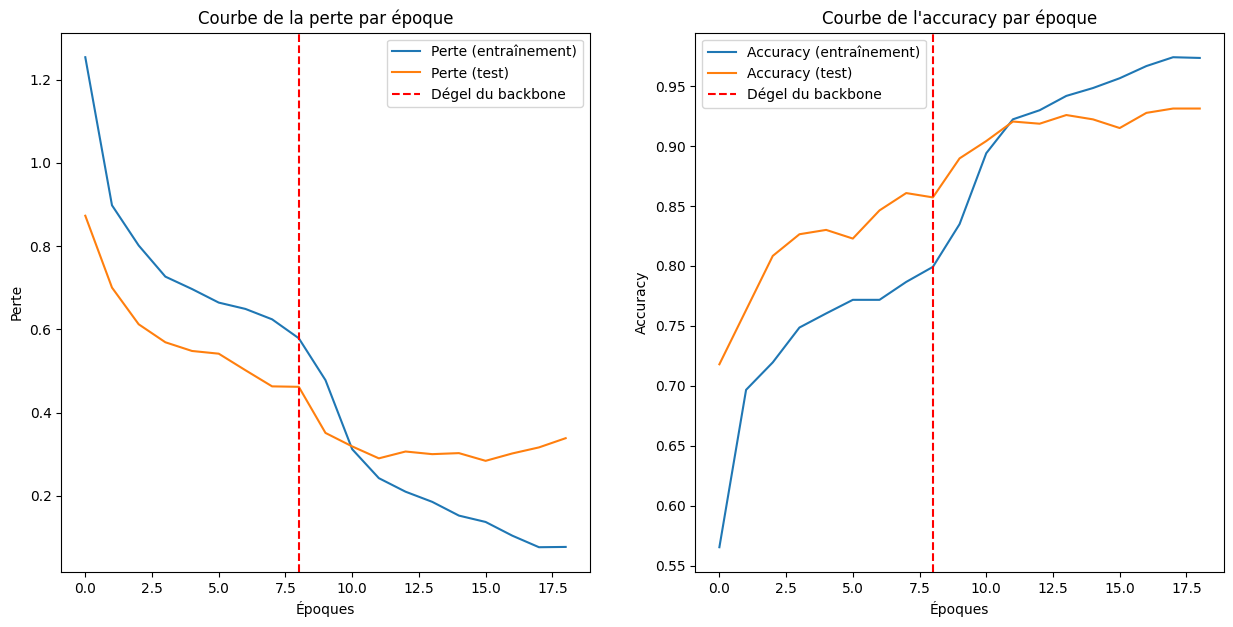

In [13]:
history = merge_history(history_frozen,history_FT)

plt.figure(figsize=(15,7))

plt.subplot(121)
# Affichage de la perte par époque
plt.plot(history['loss'], label='Perte (entraînement)')
plt.plot(history['val_loss'], label='Perte (test)')
plt.axvline(x=8, color='red', linestyle='--', label='Dégel du backbone')
plt.title('Courbe de la perte par époque')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(122)
# Affichage de l'accuracy par époque
plt.plot(history['accuracy'], label='Accuracy (entraînement)')
plt.plot(history['val_accuracy'], label='Accuracy (test)')
plt.axvline(x=8, color='red', linestyle='--', label='Dégel du backbone')
plt.title('Courbe de l\'accuracy par époque')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# Sauvegarde du modèle entraîné
fitted_model.save(f"{results_dir}/final_efficientnet.keras")

# 7. Evaluation

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(fitted_model,test_ds):
    # Prédiction
    y_true,y_pred = get_predictions_and_labels(fitted_model,test_ds)
    y_true_names = encoder.inverse_transform(y_true)
    y_pred_names = encoder.inverse_transform(y_pred)
    # Matrice de confusion
    conf_matrix = confusion_matrix(y_true_names, y_pred_names)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel("Prédictions")
    plt.ylabel("Vraies classes")
    plt.title("Matrice de confusion")
    plt.show()
    # Rapport de classification
    class_report = classification_report(y_true_names, y_pred_names)
    print("Rapport de classification :\n", class_report)
    return y_true_names,y_pred_names

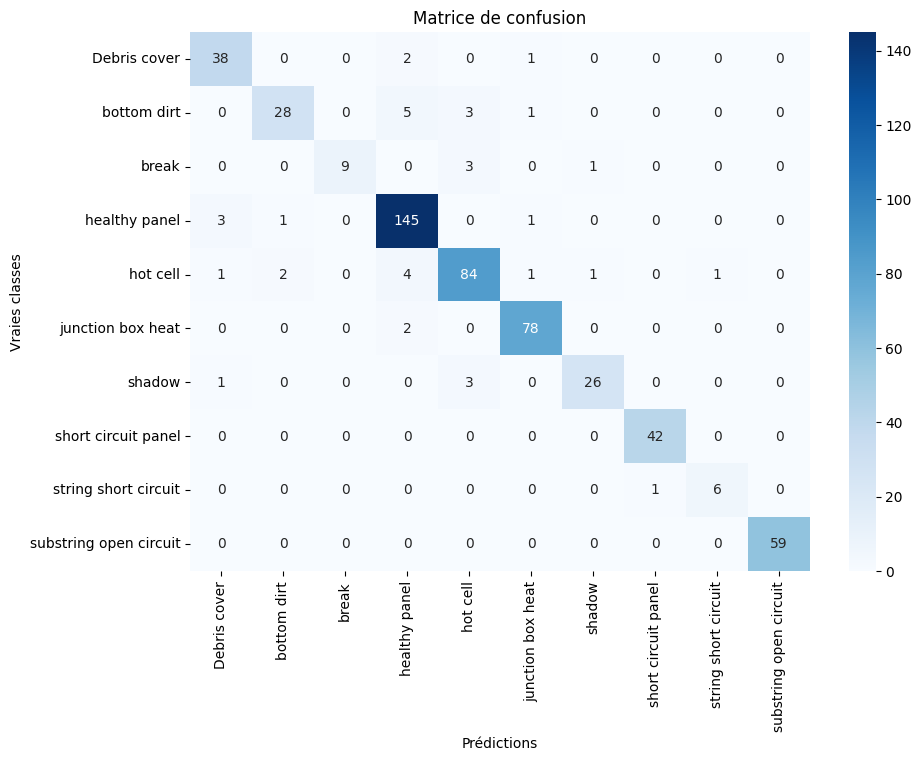

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.88      0.93      0.90        41
           bottom dirt       0.90      0.76      0.82        37
                 break       1.00      0.69      0.82        13
         healthy panel       0.92      0.97      0.94       150
              hot cell       0.90      0.89      0.90        94
     junction box heat       0.95      0.97      0.96        80
                shadow       0.93      0.87      0.90        30
   short circuit panel       0.98      1.00      0.99        42
  string short circuit       0.86      0.86      0.86         7
substring open circuit       1.00      1.00      1.00        59

              accuracy                           0.93       553
             macro avg       0.93      0.89      0.91       553
          weighted avg       0.93      0.93      0.93       553



In [16]:
y_true_names,y_pred_names = evaluate_model(fitted_model,test_ds)

On a une bonne généralisation. Avec le découpage proposé par les constructeurs du dataset (90% / 10%), on est à : **93% d'accuracy et 91% de f1-score**. Pour rappel dans leur article de recherche, le meilleur score atteint avec des modèles de Deep Learning pour les images 110x60 était de 92% d'accuracy et 91% de f1-score.

In [17]:
# Affichage des classes les + confondues
import itertools
conf_matrix_norm = confusion_matrix(y_true_names, y_pred_names,normalize='true')
classes_confondues=[]
for (reel,predit) in itertools.product(range(conf_matrix_norm.shape[0]), range(conf_matrix_norm.shape[1])):
    if (reel != predit and conf_matrix_norm[reel,predit]> 0.1):
        classes_confondues.append((encoder.classes_[reel],encoder.classes_[predit],conf_matrix_norm[reel,predit]*100))
print ("Classes confondues :")
print (*[f"Réel : {paire[0]} - Prédit : {paire[1]} ({paire[2]:.2f} %)" for paire in classes_confondues],sep = '\n')

Classes confondues :
Réel : bottom dirt - Prédit : healthy panel (13.51 %)
Réel : break - Prédit : hot cell (23.08 %)
Réel : string short circuit - Prédit : short circuit panel (14.29 %)


Les classes sous-représentées Break et String Short Circuit ont toujours des résultats un peu moins bons, comme pour les modèles de Machine Learning. Bottom Dirt est aussi parfois confondu avec Healthy Panel. En revanche, on note une amélioration assez nette concernant la classe Debris cover qui représente des défauts de petite taille.

# 8. Avec les images du format original

Entraînons notre modèle avec les images du format original (avant découpage / recadrage autour du panneau), et voyons l'impact sur les résultats.

### Chargement du dataframe

In [30]:
X_train_ori,X_test_ori,y_train_ori,y_test_ori = load_df_from_dataset(csv_pvf10,format="Ori",originalTrainTest="True")

print ("Nb d'images ensemble d'entraînement :",X_train_ori.shape[0])
print ("Nb d'images ensemble de test :",X_test_ori.shape[0])
print ("-"*20)
print ("Répartition des classes, ensemble d'entraînement :")
print(y_train_ori.value_counts(normalize=True))
print ("-"*20)
print ("Répartition des classes, ensemble de test :")
print(y_test_ori.value_counts(normalize=True))

Nb d'images ensemble d'entraînement : 5019
Nb d'images ensemble de test : 553
--------------------
Répartition des classes, ensemble d'entraînement :
Classe
healthy panel             0.271967
hot cell                  0.169356
junction box heat         0.143455
substring open circuit    0.106595
short circuit panel       0.076709
Debris cover              0.073521
bottom dirt               0.067743
shadow                    0.054393
break                     0.023511
string short circuit      0.012752
Name: proportion, dtype: float64
--------------------
Répartition des classes, ensemble de test :
Classe
healthy panel             0.271248
hot cell                  0.169982
junction box heat         0.144665
substring open circuit    0.106691
short circuit panel       0.075949
Debris cover              0.074141
bottom dirt               0.066908
shadow                    0.054250
break                     0.023508
string short circuit      0.012658
Name: proportion, dtype: float64


### Preprocessing

Comme pour le format 110x60, on passera en entrée du modèle les images en niveau de gris redimensionnées en 260x260x3.  Pour conserver les proportions d'origine de ces images de taille variable, nous faisons un redimensionnement avec padding.

Il faut adapter la fonction de preprocessing car les images sont de type .TIF dans le format original

In [31]:
# Features : récupération des chemins d'images
X_train_ori_path = X_train_ori['Chemin'].values
X_test_ori_path = X_test_ori['Chemin'].values

# Targets : Encodage des classes en entier
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_ori_enc = encoder.fit_transform(y_train_ori)
y_test_ori_enc = encoder.transform(y_test_ori)

# Fonction de preprocessing
from PIL import Image
def pil_loader(path):
    # Lire l'image avec PIL
    image = Image.open(path.numpy().decode("utf-8")).convert("L")  # "L" = niveaux de gris
    image = np.array(image, dtype=np.float32)
    image = np.repeat(image[:, :, np.newaxis], 3, axis=-1)  # Ajoute un canal pour correspondre à (H, W, 3)
    return image

def preprocess_path_ori(path, label):
    image = tf.py_function(func=pil_loader, inp=[path], Tout=tf.float32) # On encapsule la fonction Python pil_loader
    image = tf.image.resize_with_pad(image,260,260) # Redimensionnement en 260x260 avec padding
    image.set_shape([260, 260, 3])  # Définir la forme du tenseur attendue pour TensorFlow
    return image, label

# Création des datasets tensorflow
train_ori_ds = tf.data.Dataset.from_tensor_slices((X_train_ori_path, y_train_ori_enc))
test_ori_ds = tf.data.Dataset.from_tensor_slices((X_test_ori_path, y_test_ori_enc))

# Preprocessing
train_ori_ds = train_ori_ds.map(preprocess_path_ori, num_parallel_calls=tf.data.AUTOTUNE)
test_ori_ds = test_ori_ds.map(preprocess_path_ori, num_parallel_calls=tf.data.AUTOTUNE)

# Optimisation de la pipeline
BATCH_SIZE = 32
# Faire un shuffle sur train, car pas de train_test_split effectué ici => les classes ne sont pas encore mélangées
train_ori_ds = train_ori_ds.shuffle(len(X_train_ori_path)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ori_ds = test_ori_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Nombre de batch dans train_ds:", train_ori_ds.cardinality().numpy())
print("Nombre de batch dans test_ds:", test_ori_ds.cardinality().numpy())

Nombre de batch dans train_ds: 157
Nombre de batch dans test_ds: 18


### Construction du modèle et entraînement

On se base sur la même architecture et les mêmes paramètres d'entraînement que pour le format 110x60. On applique simplement une rotation en plus dans les augmentations de données.

In [32]:
# On entraîne le modèle sur l'ensemble train du format original
fitted_model_ori,history_frozen_ori,history_FT_ori = train_model(train_ori_ds,test_ori_ds,add_rotation=True)

Epoch 1/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.4375 - loss: 1.5973 - val_accuracy: 0.6600 - val_loss: 1.0053
Epoch 2/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.6254 - loss: 1.0312 - val_accuracy: 0.7396 - val_loss: 0.8192
Epoch 3/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.6799 - loss: 0.9044 - val_accuracy: 0.7324 - val_loss: 0.7615
Epoch 4/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.6961 - loss: 0.8695 - val_accuracy: 0.7486 - val_loss: 0.7252
Epoch 5/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.7095 - loss: 0.8125 - val_accuracy: 0.7233 - val_loss: 0.7259
Epoch 6/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.7069 - loss: 0.8044 - val_accuracy: 0.7794 - val_loss: 0.6503
Epoch 7/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.7109 - loss: 0.8095 - val_accuracy: 0.7866 - val_loss: 0.6521
Epoch 8/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.7433 - loss: 0.7392 - val_accuracy: 0.

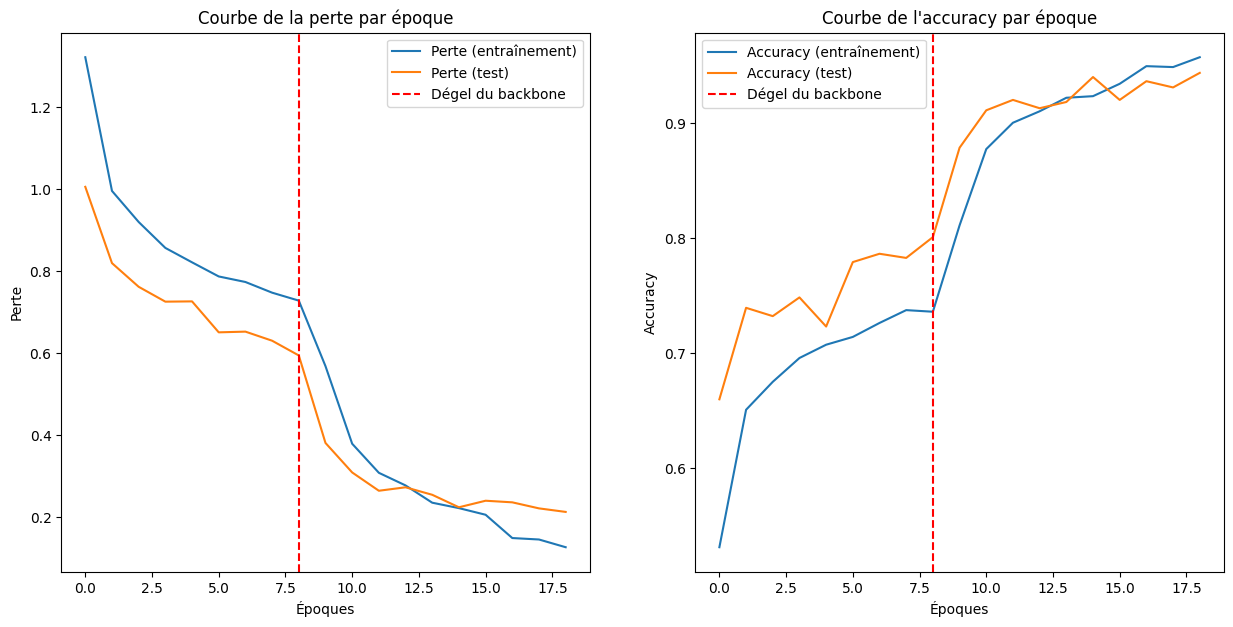

In [33]:
history = merge_history(history_frozen_ori,history_FT_ori)

plt.figure(figsize=(15,7))

plt.subplot(121)
# Affichage de la perte par époque
plt.plot(history['loss'], label='Perte (entraînement)')
plt.plot(history['val_loss'], label='Perte (test)')
plt.axvline(x=8, color='red', linestyle='--', label='Dégel du backbone')
plt.title('Courbe de la perte par époque')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(122)
# Affichage de l'accuracy par époque
plt.plot(history['accuracy'], label='Accuracy (entraînement)')
plt.plot(history['val_accuracy'], label='Accuracy (test)')
plt.axvline(x=8, color='red', linestyle='--', label='Dégel du backbone')
plt.title('Courbe de l\'accuracy par époque')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluation

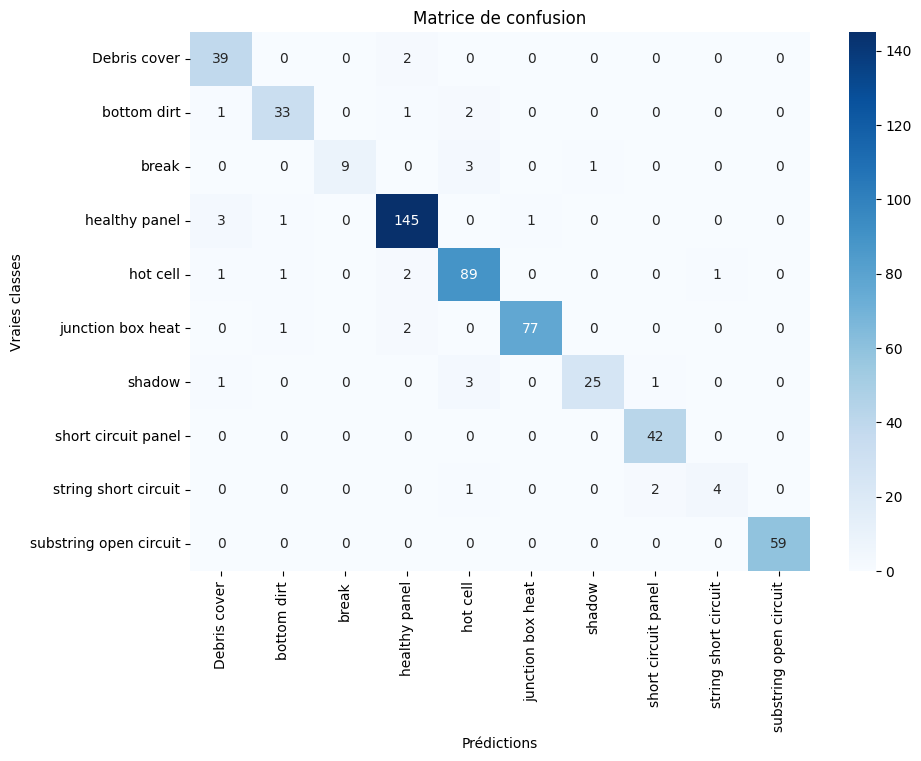

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.87      0.95      0.91        41
           bottom dirt       0.92      0.89      0.90        37
                 break       1.00      0.69      0.82        13
         healthy panel       0.95      0.97      0.96       150
              hot cell       0.91      0.95      0.93        94
     junction box heat       0.99      0.96      0.97        80
                shadow       0.96      0.83      0.89        30
   short circuit panel       0.93      1.00      0.97        42
  string short circuit       0.80      0.57      0.67         7
substring open circuit       1.00      1.00      1.00        59

              accuracy                           0.94       553
             macro avg       0.93      0.88      0.90       553
          weighted avg       0.94      0.94      0.94       553



In [34]:
y_true_ori_names,y_pred_ori_names = evaluate_model(fitted_model_ori,test_ori_ds)

Avec les image dans le format original, on est à : **94% d'accuracy et 90% de f1-score**, soit équivalent au format 110x60 ! Pour rappel dans leur article de recherche, le meilleur score atteint avec des modèles de Deep Learning pour les images au format original était de 91% d'accuracy et 87% de f1-score.

In [45]:
# Sauvegarde du modèle entraîné
fitted_model_ori.save(f"{results_dir}/final_efficientnet_ori.keras")

# 9. Avec les images en format 112x112

Entraînons notre modèle avec les images du format 112x112 (ajout de bandes noires par rapport au format 110x60 pour obtenir un format carré). Ainsi les images passées en entrée de notre modèle ne seront pas déformées, voyons l'impact sur les résultats.

### Chargement du dataframe

In [24]:
X_train_112,X_test_112,y_train_112,y_test_112 = load_df_from_dataset(csv_pvf10,format="112x112",originalTrainTest="True")

print ("Nb d'images ensemble d'entraînement :",X_train_112.shape[0])
print ("Nb d'images ensemble de test :",X_test_112.shape[0])
print ("-"*20)
print ("Répartition des classes, ensemble d'entraînement :")
print(y_train_112.value_counts(normalize=True))
print ("-"*20)
print ("Répartition des classes, ensemble de test :")
print(y_test_112.value_counts(normalize=True))

Nb d'images ensemble d'entraînement : 5020
Nb d'images ensemble de test : 552
--------------------
Répartition des classes, ensemble d'entraînement :
Classe
healthy panel             0.271912
hot cell                  0.169323
junction box heat         0.143426
substring open circuit    0.106773
short circuit panel       0.076693
Debris cover              0.073506
bottom dirt               0.067729
shadow                    0.054382
break                     0.023506
string short circuit      0.012749
Name: proportion, dtype: float64
--------------------
Répartition des classes, ensemble de test :
Classe
healthy panel             0.271739
hot cell                  0.170290
junction box heat         0.144928
substring open circuit    0.105072
short circuit panel       0.076087
Debris cover              0.074275
bottom dirt               0.067029
shadow                    0.054348
break                     0.023551
string short circuit      0.012681
Name: proportion, dtype: float64


### Preprocessing

Comme pour le format 110x60, on passera en entrée du modèle les images en niveau de gris redimensionnées en 260x260x3

In [25]:
# Features : récupération des chemins d'images
X_train_112_path = X_train_112['Chemin'].values
X_test_112_path = X_test_112['Chemin'].values

# Targets : Encodage des classes en entier
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_112_enc = encoder.fit_transform(y_train_112)
y_test_112_enc = encoder.transform(y_test_112)

# Création des datasets tensorflow
train_112_ds = tf.data.Dataset.from_tensor_slices((X_train_112_path, y_train_112_enc))
test_112_ds = tf.data.Dataset.from_tensor_slices((X_test_112_path, y_test_112_enc))

# Preprocessing
train_112_ds = train_112_ds.map(preprocess_path, num_parallel_calls=tf.data.AUTOTUNE)
test_112_ds = test_112_ds.map(preprocess_path, num_parallel_calls=tf.data.AUTOTUNE)

# Optimisation de la pipeline
BATCH_SIZE = 32
# Faire un shuffle sur train, car pas de train_test_split effectué ici => les classes ne sont pas encore mélangées
train_112_ds = train_112_ds.shuffle(len(X_train_112_path)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_112_ds = test_112_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Nombre de batch dans train_ds:", train_112_ds.cardinality().numpy())
print("Nombre de batch dans test_ds:", test_112_ds.cardinality().numpy())

Nombre de batch dans train_ds: 157
Nombre de batch dans test_ds: 18


### Entraînement

On se base sur la même architecture et les mêmes paramètres d'entraînement que pour le format 110x60.

In [37]:
# On entraîne le modèle sur l'ensemble train du format 112x112
fitted_model_112,history_frozen_112,history_FT_112 = train_model(train_112_ds,test_112_ds)

Epoch 1/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.4361 - loss: 1.5677 - val_accuracy: 0.7065 - val_loss: 0.8745
Epoch 2/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.6509 - loss: 1.0231 - val_accuracy: 0.7428 - val_loss: 0.7467
Epoch 3/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 157s 987ms/step - accuracy: 0.7091 - loss: 0.8549 - val_accuracy: 0.7971 - val_loss: 0.6618
Epoch 4/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 152s 955ms/step - accuracy: 0.7352 - loss: 0.7780 - val_accuracy: 0.7971 - val_loss: 0.6020
Epoch 5/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 153s 959ms/step - accuracy: 0.7445 - loss: 0.7616 - val_accuracy: 0.8333 - val_loss: 0.5638
Epoch 6/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 152s 957ms/step - accuracy: 0.7584 - loss: 0.7069 - val_accuracy: 0.8188 - val_loss: 0.5422
Epoch 7/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 150s 946ms/step - accuracy: 0.7680 - loss: 0.6772 - val_accuracy: 0.8188 - val_loss: 0.5606
Epoch 8/9
157/157 ━━━━━━━━━━━━━━━━━━━━ 152s 953ms/step - accuracy: 0.7779 - loss: 0.6213 

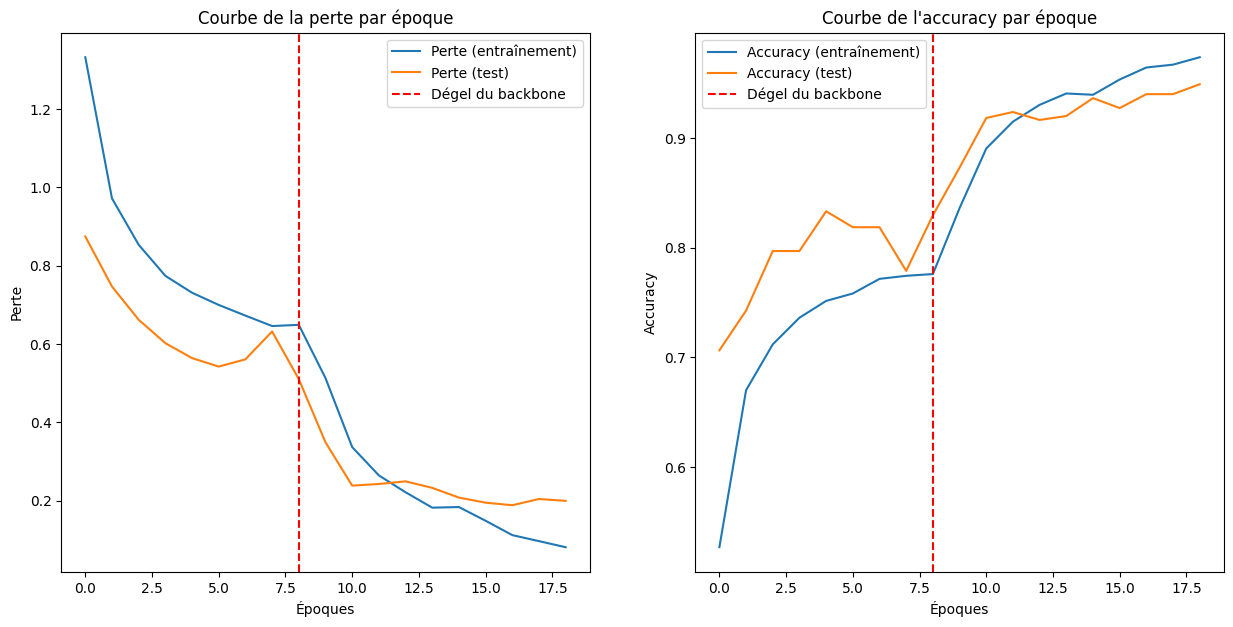

In [38]:
# On concatène l'historique avant et après dégel du backbone
history = merge_history(history_frozen_112,history_FT_112)

plt.figure(figsize=(15,7))

plt.subplot(121)
# Affichage de la perte par époque
plt.plot(history['loss'], label='Perte (entraînement)')
plt.plot(history['val_loss'], label='Perte (test)')
plt.axvline(x=8, color='red', linestyle='--', label='Dégel du backbone')
plt.title('Courbe de la perte par époque')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(122)
# Affichage de l'accuracy par époque
plt.plot(history['accuracy'], label='Accuracy (entraînement)')
plt.plot(history['val_accuracy'], label='Accuracy (test)')
plt.axvline(x=8, color='red', linestyle='--', label='Dégel du backbone')
plt.title('Courbe de l\'accuracy par époque')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluation

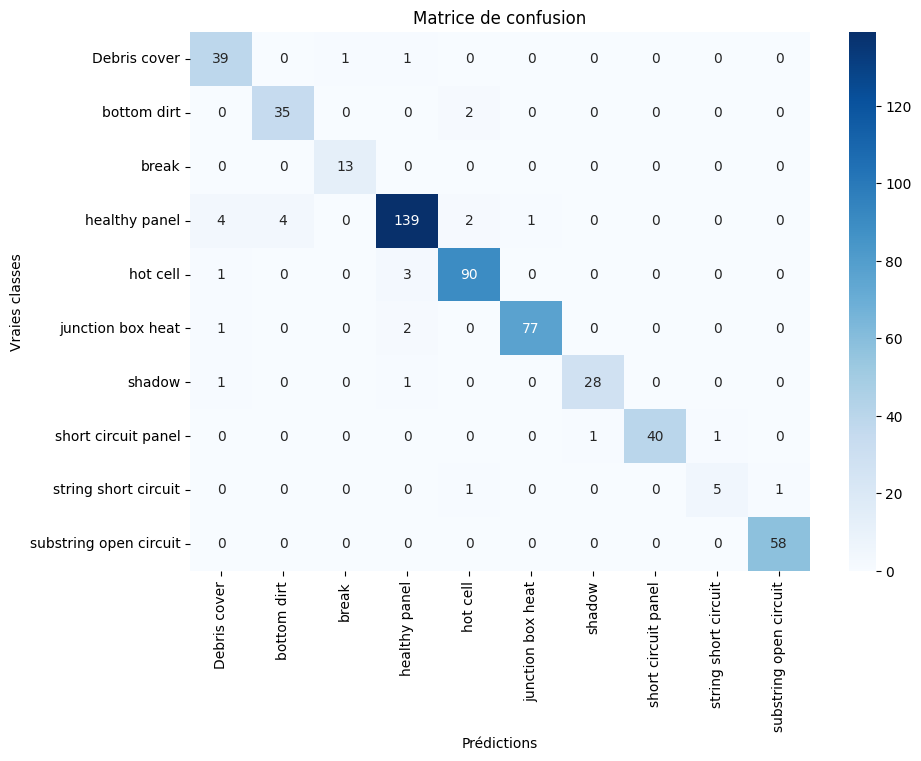

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.85      0.95      0.90        41
           bottom dirt       0.90      0.95      0.92        37
                 break       0.93      1.00      0.96        13
         healthy panel       0.95      0.93      0.94       150
              hot cell       0.95      0.96      0.95        94
     junction box heat       0.99      0.96      0.97        80
                shadow       0.97      0.93      0.95        30
   short circuit panel       1.00      0.95      0.98        42
  string short circuit       0.83      0.71      0.77         7
substring open circuit       0.98      1.00      0.99        58

              accuracy                           0.95       552
             macro avg       0.93      0.93      0.93       552
          weighted avg       0.95      0.95      0.95       552



In [39]:
y_true_112_names,y_pred_112_names = evaluate_model(fitted_model_112,test_112_ds)

Avec les image dans le format 112x112, on est à : **95% d'accuracy et 93% de f1-score**, soit mieux que le format 110x60. Le traitement pour passer les images en 112x112 apporte ici un gain pour cette modélisation.

In [46]:
# Sauvegarde du modèle entraîné
fitted_model_112.save(f"{results_dir}/final_efficientnet_112.keras")

# 10. Avec les images en RGB

Passons en entrée de notre modèle les images du format 110x60 en pseudo-couleurs infrarouges, et voyons l'impact sur les résultats

### Preprocessing

Comme pour le format 110x60, on passera en entrée du modèle les images redimensionnées en 260x260x3, mais sans conversion préalable en niveau de gris.

In [40]:
# Création des datasets tensorflow
train_rgb_ds = tf.data.Dataset.from_tensor_slices((X_train_path, y_train_enc))
val_rgb_ds = tf.data.Dataset.from_tensor_slices((X_val_path, y_val_enc))
test_rgb_ds = tf.data.Dataset.from_tensor_slices((X_test_path, y_test_enc))

# Fonction de preprocessing
def preprocess_path_rgb(path, label):
    image = tf.io.read_file(path) # Lecture du fichier
    image = tf.image.decode_png(image, channels=3) # Chargement de l'image 
    image = tf.image.resize(image, [260, 260]) # Redimensionnement en 260x260
    return image, label

# Preprocessing
train_rgb_ds = train_rgb_ds.map(preprocess_path_rgb, num_parallel_calls=tf.data.AUTOTUNE)
val_rgb_ds = val_rgb_ds.map(preprocess_path_rgb, num_parallel_calls=tf.data.AUTOTUNE)
test_rgb_ds = test_rgb_ds.map(preprocess_path_rgb, num_parallel_calls=tf.data.AUTOTUNE)

# Optimisation de la pipeline
BATCH_SIZE = 32
train_rgb_ds = train_rgb_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_rgb_ds = val_rgb_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_rgb_ds = test_rgb_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Concaténation train et val
final_train_rgb_ds = train_rgb_ds.concatenate(val_rgb_ds)

print("Nombre de batch dans final_train_rgb_ds:", final_train_rgb_ds.cardinality().numpy())
print("Nombre de batch dans test_rgb_ds:", test_rgb_ds.cardinality().numpy())

Nombre de batch dans final_train_rgb_ds: 158
Nombre de batch dans test_rgb_ds: 18


### Entraînement

On se base sur la même architecture et les mêmes paramètres d'entraînement que pour les images en niveau de gris.

In [41]:
# On entraîne le modèle sur l'ensemble train du format 110x60 en rgb
fitted_model_rgb,history_frozen_rgb,history_FT_rgb = train_model(final_train_rgb_ds,test_rgb_ds)

Epoch 1/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 167s 976ms/step - accuracy: 0.4827 - loss: 1.4976 - val_accuracy: 0.7541 - val_loss: 0.7917
Epoch 2/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 149s 944ms/step - accuracy: 0.7016 - loss: 0.9064 - val_accuracy: 0.8011 - val_loss: 0.6427
Epoch 3/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 148s 940ms/step - accuracy: 0.7266 - loss: 0.7981 - val_accuracy: 0.8137 - val_loss: 0.5758
Epoch 4/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 149s 943ms/step - accuracy: 0.7661 - loss: 0.7299 - val_accuracy: 0.8192 - val_loss: 0.5423
Epoch 5/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 149s 942ms/step - accuracy: 0.7719 - loss: 0.6784 - val_accuracy: 0.8427 - val_loss: 0.4837
Epoch 6/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 149s 945ms/step - accuracy: 0.7873 - loss: 0.6437 - val_accuracy: 0.8373 - val_loss: 0.4878
Epoch 7/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 148s 938ms/step - accuracy: 0.7888 - loss: 0.6197 - val_accuracy: 0.8517 - val_loss: 0.4814
Epoch 8/9
158/158 ━━━━━━━━━━━━━━━━━━━━ 148s 938ms/step - accuracy: 0.8114 - loss: 0

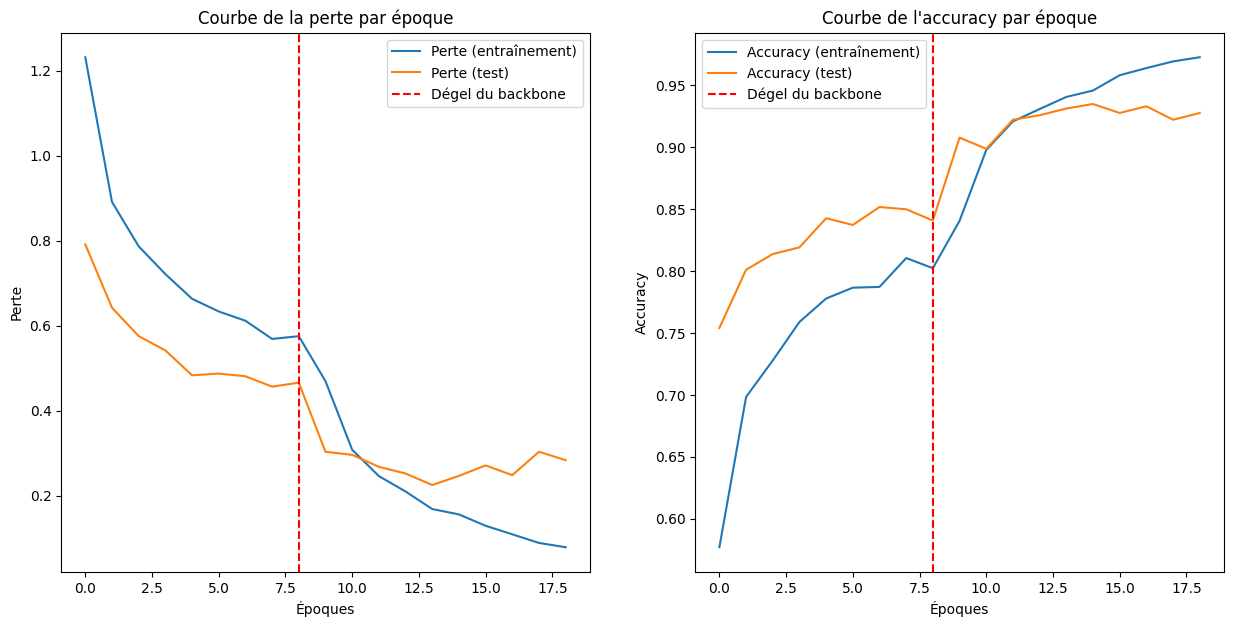

In [42]:
# On concatène l'historique avant et après dégel du backbone
history = merge_history(history_frozen_rgb,history_FT_rgb)

plt.figure(figsize=(15,7))

plt.subplot(121)
# Affichage de la perte par époque
plt.plot(history['loss'], label='Perte (entraînement)')
plt.plot(history['val_loss'], label='Perte (test)')
plt.axvline(x=8, color='red', linestyle='--', label='Dégel du backbone')
plt.title('Courbe de la perte par époque')
plt.xlabel('Époques')
plt.ylabel('Perte')
plt.legend()

plt.subplot(122)
# Affichage de l'accuracy par époque
plt.plot(history['accuracy'], label='Accuracy (entraînement)')
plt.plot(history['val_accuracy'], label='Accuracy (test)')
plt.axvline(x=8, color='red', linestyle='--', label='Dégel du backbone')
plt.title('Courbe de l\'accuracy par époque')
plt.xlabel('Époques')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Evaluation

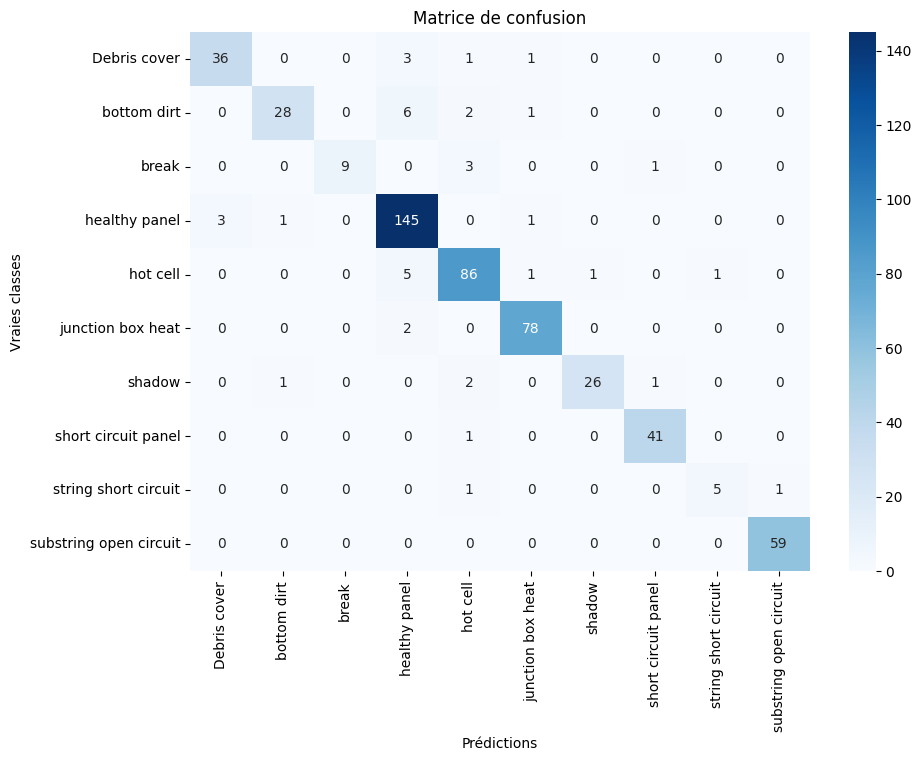

Rapport de classification :
                         precision    recall  f1-score   support

          Debris cover       0.92      0.88      0.90        41
           bottom dirt       0.93      0.76      0.84        37
                 break       1.00      0.69      0.82        13
         healthy panel       0.90      0.97      0.93       150
              hot cell       0.90      0.91      0.91        94
     junction box heat       0.95      0.97      0.96        80
                shadow       0.96      0.87      0.91        30
   short circuit panel       0.95      0.98      0.96        42
  string short circuit       0.83      0.71      0.77         7
substring open circuit       0.98      1.00      0.99        59

              accuracy                           0.93       553
             macro avg       0.93      0.87      0.90       553
          weighted avg       0.93      0.93      0.93       553



In [43]:
y_true_rgb_names,y_pred_rgb_names = evaluate_model(fitted_model_rgb,test_rgb_ds)

Avec les images 110x60 en pseudo-couleurs, on est à : **93% d'accuracy et 90% de f1-score**, soit similaire aux images en niveau de gris.

In [44]:
# Sauvegarde du modèle entraîné avec les images RGB
fitted_model_rgb.save(f"{results_dir}/final_efficientnet_rgb.keras")

# 11. Interprétabilité

L'interprétabilité se fera sur le modèle entraîné avec les images du format 112x112 pour lequel on a obtenu les meilleurs résultats.

On récupère ces images après preprocessing (redimensionnées en 260x260x3 et converties en niveaux de gris)

Nous allons étudier l'interprétabilité de ces images par notre réseau de neurones avec SHAP.

In [ ]:
# Récupérer une image de chaque classe d'un dataset
def get_one_image_per_class(dataset, num_classes=10):
    # Stockage des images dans un dictionnaire
    images_per_class = {} 
    # Pour chaque batch
    for batch_images, batch_labels in dataset:
        # Pour chaque image / label
        for img, label in zip(batch_images, batch_labels):
            # Convertir les images en array d'entiers
            img = img.numpy().astype(np.uint8)
            # Convertir les labels en nom de classe
            label = encoder.classes_[label.numpy()]
            # Si la classe n'a pas encore été ajoutée
            if label not in images_per_class:
                # On l'ajoute avec l'image associée
                images_per_class[label] = img
                # On s'arrête quand on atteint le nb de classes demandé
                if len(images_per_class) == num_classes:
                    return images_per_class

# On récupère ue image de chaque classe dans l'ensemble test 112x112
# C'est un dictionnaire dont la clé est le nom de la classe
my_images_dict = get_one_image_per_class(test_112_ds)              

In [28]:
# Chargement du modèle entraîné sur les images 112x112 en niveaux de gris
from tensorflow.keras.models import load_model
model_loaded = load_model(f"{results_dir}/final_efficientnet_112.keras")

In [29]:
# On affiche les probabilités prédites pour ces images
my_images = np.array(list(my_images_dict.values()))
my_preds = model_loaded.predict(my_images)
display(pd.DataFrame(np.round(my_preds*100,2),index=my_images_dict.keys(),columns=encoder.classes_))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


,Debris cover,bottom dirt,break,healthy panel,hot cell,junction box heat,shadow,short circuit panel,string short circuit,substring open circuit
substring open circuit,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,100.00
short circuit panel,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.000000,99.910004,0.080000,0.00
string short circuit,0.000000,0.000000,0.00,0.000000,0.01,0.00,0.000000,0.010000,99.900002,0.09
Debris cover,99.349998,0.000000,0.01,0.020000,0.20,0.42,0.000000,0.000000,0.000000,0.00
shadow,0.110000,0.000000,0.02,0.000000,0.01,0.00,97.239998,0.670000,1.030000,0.92
bottom dirt,0.000000,99.970001,0.00,0.020000,0.01,0.00,0.000000,0.000000,0.000000,0.00
break,0.000000,0.000000,100.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00
junction box heat,0.080000,0.080000,0.00,86.889999,0.01,12.94,0.000000,0.000000,0.000000,0.00
hot cell,0.060000,10.230000,0.02,0.890000,88.68,0.04,0.040000,0.000000,0.010000,0.00
healthy panel,0.450000,0.770000,0.00,98.629997,0.15,0.00,0.000000,0.000000,0.000000,0.00


Sur ces 10 images, le modèle s'est trompé sur une seule : la Junction box heat a été prédite en Healthy Panel.

d:\Sources\DS-projet\SEP24-CDS-PHOTOVOLTAIQUE\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
PartitionExplainer explainer: 11it [20:29, 122.96s/it]                        


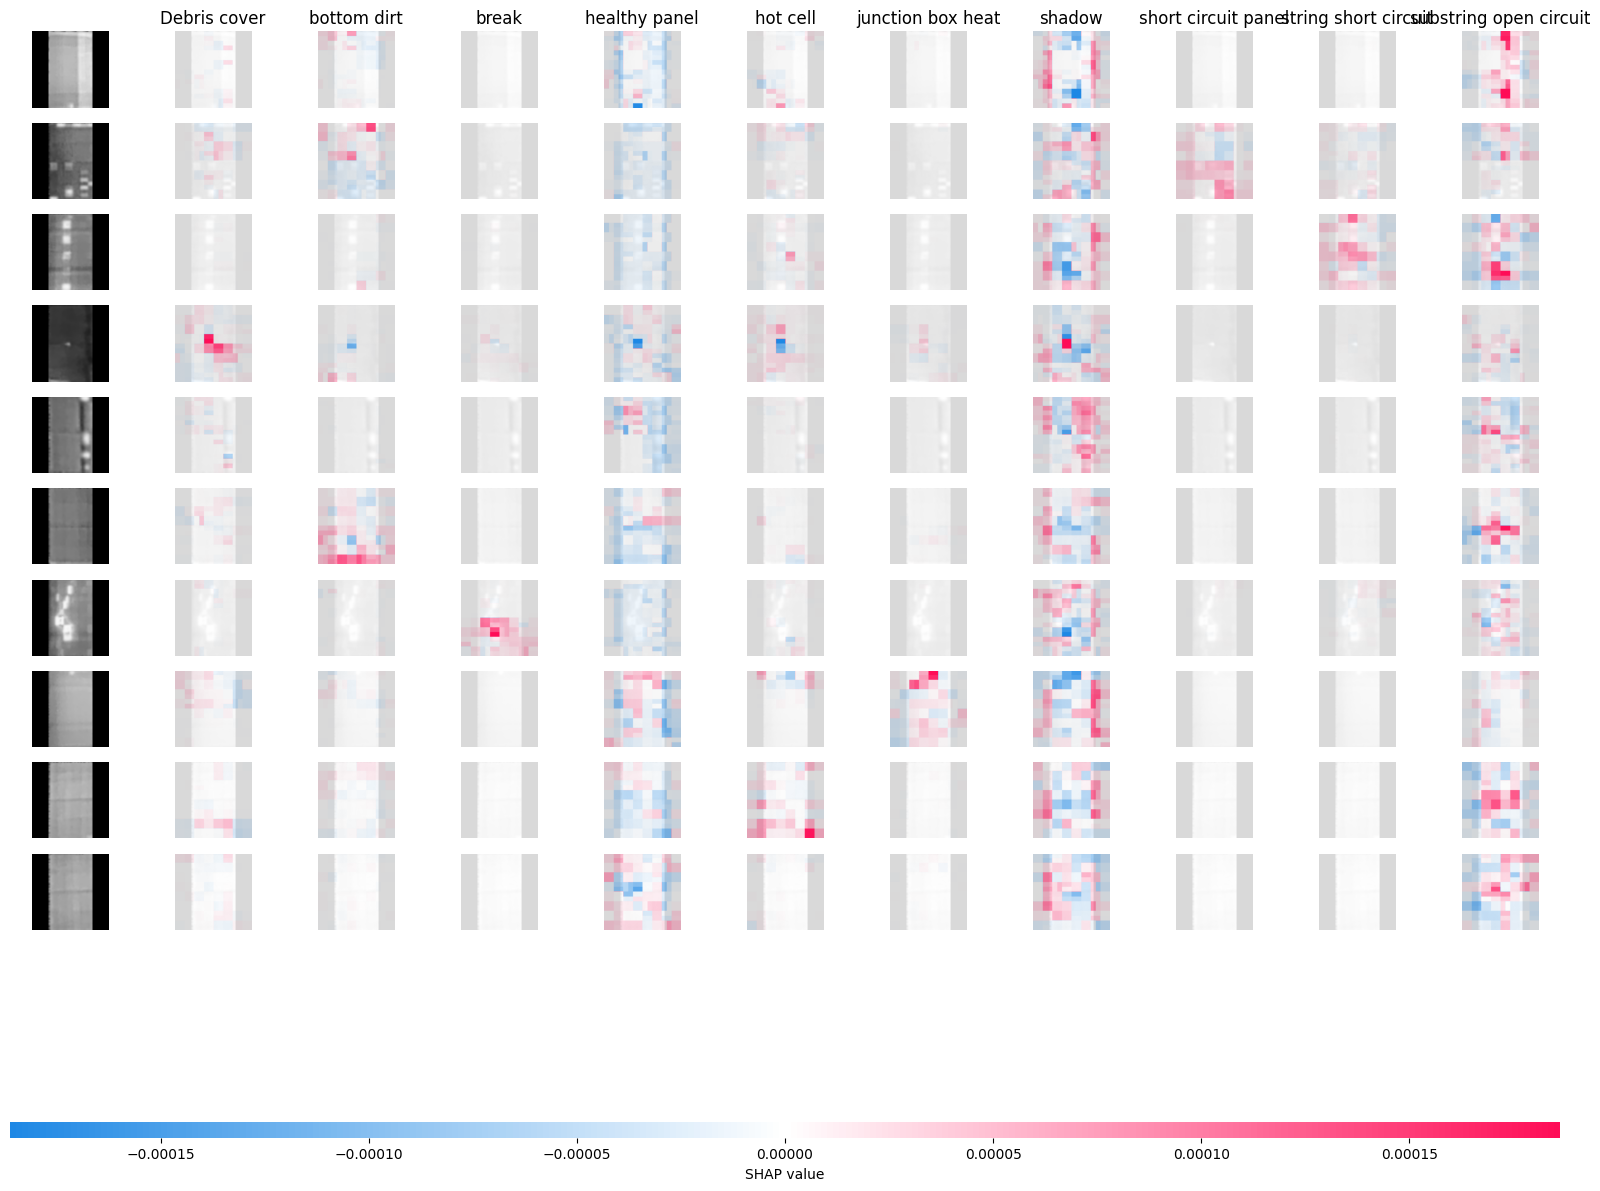

In [30]:
# Initialiser le masker SHAP
import shap

# Initialiser le masker SHAP
masker = shap.maskers.Image("inpaint_telea", (260,260,3))

# Créer l'explainer SHAP
explainer = shap.Explainer(model_loaded, masker, output_names=encoder.classes_)

# Calculer les valeurs SHAP pour les images qu'on veut expliquer
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
shap_values = explainer(my_images, max_evals=1000)

# Afficher les images SHAP
shap.image_plot(shap_values)

Vérifions les zones utilisées par notre modèle pour chacune des images : 
- substring open circuit : la bande verticale en défaut à droite a bien été identifiée
- short circuit panel : les grosses variations de température sur les différentes cellules (principalement en bas à droite) ont été identifiées
- string short circuit : les cellules en défaut à gauche de l'image ont bien été identifiées
- debris cover : la zone du débris a bien été identifiée
- shadow : la zone de contraste à droite a bien été identifiée.
- bottom dirt : la bande de salissure en bas de l'image, bien que peu visible à l'oeil nu, a bien été repérée par le modèle
- break : les zones de fracture les plus impactées ont bien été identifiées
- junction box heat (prédit healthy à tort): le modèle a détecté une variation de température, en haut au centre de l'image, favorable à un défaut Junction box, mais pas suffisante => il a classé le panneau Healthy.
- hot cell : la cellule en défaut en bas à droite, bien que peu visible à l'oeil nu, a bien été repérée par le modèle
- healthy panel : différentes zones de l'image où "il ne se passe rien" ont contribué à la classification Healthy

**Les zones considérées par notre modèle sont cohérentes avec les classes prédites**

Notre modèle peut parfois se tromper, par exemple lorsque le défaut concerné entraîne des variations trop faibles par rapport au bruit ambiant (junction box heat...). A noter que parmi ces cas d'erreur, les défauts en question ne sont pas non plus toujours faciles à distinguer pour un observateur humain.

# 12. Généralisation hors dataset

In [44]:
# Chargement du modèle entraîné sur les images du format 110x60 en niveaux de gris
from tensorflow.keras.models import load_model
model_loaded = load_model(f"{results_dir}/final_efficientnet.keras")
model_loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 260, 260, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 260, 260, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,514,242 (97.33 MB)

 Trainable params: 8,190,796 (31.25 MB)

 Non-trainable params: 941,852 (3.59 MB)

 Optimizer params: 16,381,594 (62.49 MB)

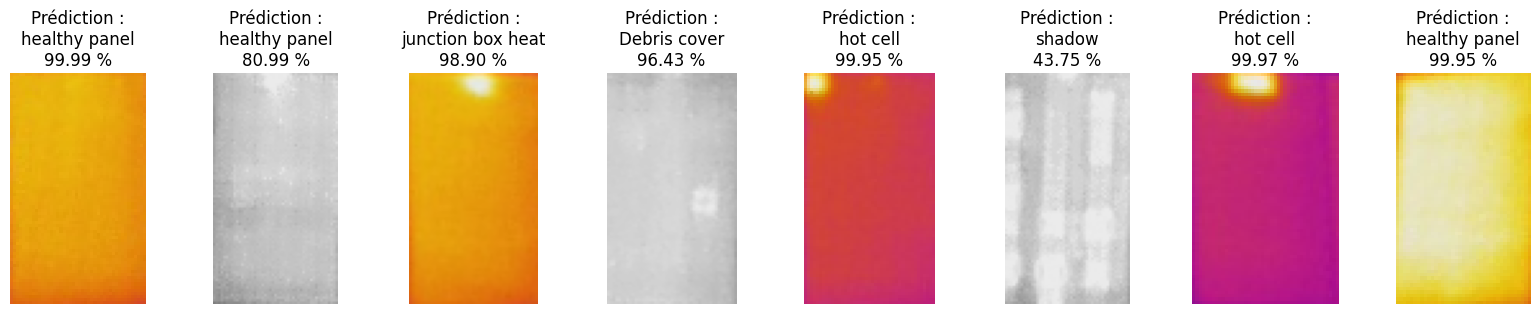

In [46]:
import matplotlib.image as mpimg

# Quelques images de test hors dataset pour la prédiction
plt.figure(figsize=(20, 3))

for i,unit_test_path in enumerate(["UT_images_ext/UT_healthy.png",
                                   "UT_images_ext/UT_junction_box.png",
                                   "UT_images_ext/UT_junction_box_2.png",
                                   "UT_images_ext/UT_one_cell.png",
                                   "UT_images_ext/UT_one_cell_2.png",
                                   "UT_images_ext/UT_multi_cell.png",
                                   "UT_images_ext/UT_multi_cell_2.png",
                                   "UT_images_ext/UT_module.png"]):
    # Faire passer l'image dans le preprocessing
    img,_ = preprocess_path(unit_test_path,"")
    # Ajouter une dimension (=> conforme à l'entrée du modèle en batches)
    img = np.expand_dims(img, axis = 0)
    # Prédire les résultats pour l'image
    preds = model_loaded.predict(img,verbose=0)
    class_pred = encoder.classes_[np.argmax(preds,axis=1)[0]]
    proba_class_pred = np.max(preds,axis=1)[0] * 100
    # Afficher l'image et sa classe prédite
    plt.subplot(1, 8, i+1)
    img = mpimg.imread(unit_test_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prédiction :\n{class_pred}\n{proba_class_pred:.2f} %")

plt.show()

Même si ce sont des images extérieures au dataset original, les prédictions sont correctes dans l'ensemble, sauf pour :
- 2ème image (défaut junction box) : la variation de température est ici trop faible par rapport au bruit
- 6ème image (défaut multi-cellules) : le modèle hésite sur le type de défauts, il ne donne qu'une probabilité de 44% à Shadow